# AWS Architecture Application - New York Taxi Company

## Data visualization

In [1]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [82]:
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight');
plt.rcParams['font.size'] = 14;
plt.figure(figsize=(12,5));
palette = sns.color_palette('Paired', 10);

import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import skew

<Figure size 864x360 with 0 Axes>

In [3]:
data = pd.read_csv("train.csv", nrows=1000000)
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
data = data.drop(["key"],axis=1)

In [5]:
size_before = len(data)
data = data.drop_duplicates()
size_after = len(data)
print(str(size_before - size_after) + " duplicates were removed.")

0 duplicates were removed.


In [6]:
100 * data.isnull().sum().sort_values(ascending=False)/len(data)

dropoff_longitude    0.001
dropoff_latitude     0.001
fare_amount          0.000
pickup_datetime      0.000
pickup_longitude     0.000
pickup_latitude      0.000
passenger_count      0.000
dtype: float64

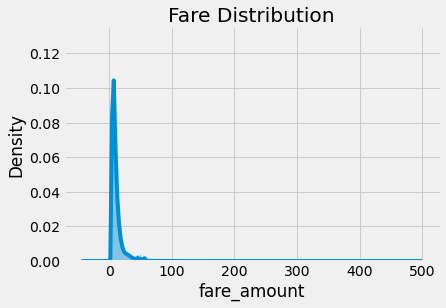

In [7]:
def plot_dist(series=data["fare_amount"], title = "Fare Distribution"):
    sns.histplot(series, kde=True, stat='density',discrete=True)
    sns.despine()
    plt.title(title);
    plt.show()
plot_dist()

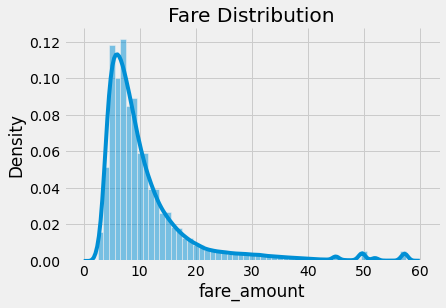

In [8]:
data = data[data.fare_amount.between(0,60)]
plot_dist(data.fare_amount)

In [9]:
data['fare-bin'] = pd.cut(data['fare_amount'], bins = list(range(0, 50, 5)), include_lowest=True).astype('str')

# Uppermost bin
data['fare-bin'] = data['fare-bin'].replace(np.nan, '[45+]')

# apply this to clean up the first bin's label
data['fare-bin'] = data['fare-bin'].apply(lambda x: x.replace('-0.001', '0'))

# sort by fare the correct look in the chart
data = data.sort_values(by='fare_amount')

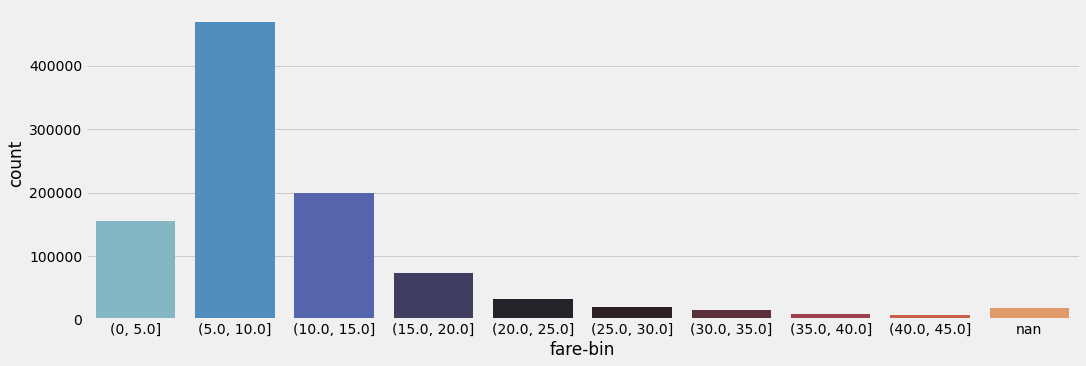

In [10]:
sns.catplot(x="fare-bin", kind="count", palette= "icefire", data=data, height=5, aspect=3);
sns.despine()
plt.show()

In [11]:
data.passenger_count.describe()

count    997297.000000
mean          1.685096
std           1.324201
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         208.000000
Name: passenger_count, dtype: float64

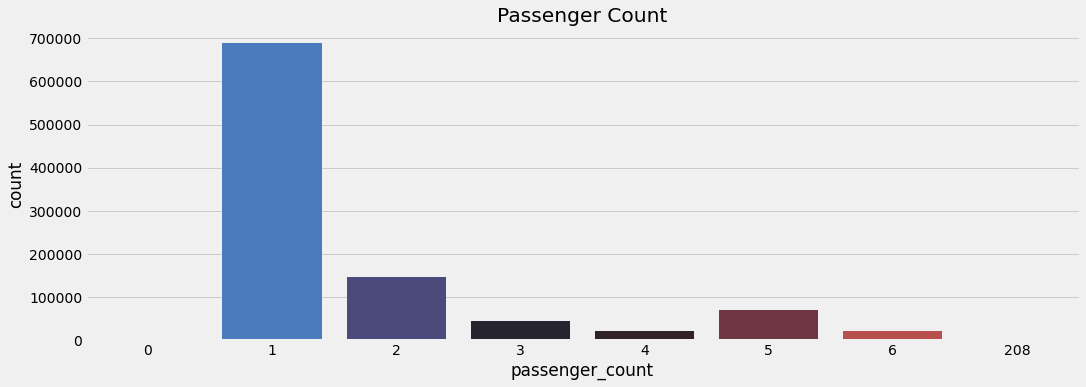

In [12]:
sns.catplot(x="passenger_count", kind="count", palette="icefire", data=data, height=5, aspect=3);
sns.despine()
plt.title('Passenger Count');
plt.show()

In [13]:
def extract_time_features(df):
    timezone_name = 'America/New_York'
    time_column = "pickup_datetime"
    df.index = pd.to_datetime(df[time_column])
    df.index = df.index.tz_convert(timezone_name)
    df["dow"] = df.index.weekday
    df["hour"] = df.index.hour
    df["month"] = df.index.month
    df["year"] = df.index.year
    return df.reset_index(drop=True)

In [14]:
data = extract_time_features(data.drop(["fare-bin"], axis=1))
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dow,hour,month,year
0,0.0,2015-04-15 14:02:39 UTC,-73.937378,40.758450,-73.937447,40.758450,1,2,10,4,2015
1,0.0,2015-04-08 00:47:30 UTC,0.000000,0.000000,-73.937698,40.758118,1,1,20,4,2015
2,0.0,2010-02-20 09:51:27 UTC,-73.877376,40.772415,-73.877403,40.772391,1,5,4,2,2010
3,0.0,2015-05-27 23:10:03 UTC,-73.994125,40.741131,-73.994125,40.741131,1,2,19,5,2015
4,0.0,2013-08-05 06:45:54 UTC,-73.982354,40.679971,-73.982354,40.679971,1,0,2,8,2013


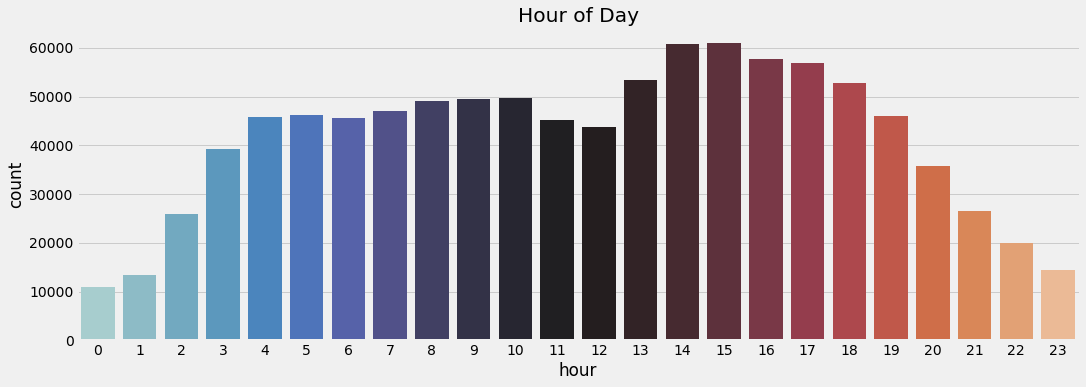

In [15]:
sns.catplot(x="hour", kind="count", palette="icefire", data=data, height=5, aspect=3);
sns.despine()
plt.title('Hour of Day');
plt.show()

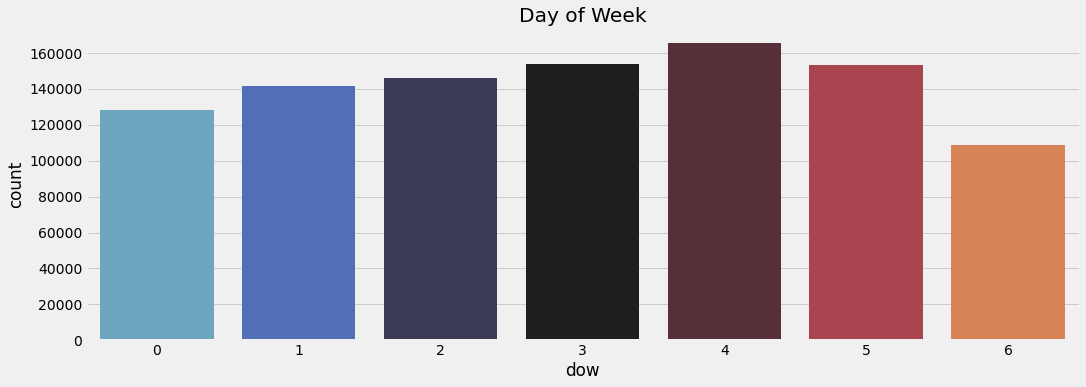

In [16]:
sns.catplot(x="dow", kind="count", palette="icefire", data=data, height=5, aspect=3);
sns.despine()
plt.title('Day of Week');
plt.show()

In [17]:
data_test = pd.read_csv("test.csv")

In [18]:
for col in ["pickup_latitude","pickup_longitude","dropoff_latitude","dropoff_longitude"]:
    MIN = data_test[col].min()
    MAX = data_test[col].max()
    
    print(col, MIN, MAX)

pickup_latitude 40.573143 41.709555
pickup_longitude -74.252193 -72.986532
dropoff_latitude 40.568973 41.696683
dropoff_longitude -74.263242 -72.990963


In [19]:
data = data[data["pickup_latitude"].between(left = 40, right = 42 )]
data = data[data["pickup_longitude"].between(left = -74.3, right = -72.9 )]
data = data[data["dropoff_latitude"].between(left = 40, right = 42 )]
data = data[data["dropoff_longitude"].between(left = -74, right = -72.9 )]

In [20]:
center_location = [40.758896, -73.985130]
m = folium.Map(location=center_location, control_scale=True, zoom_start=11)

In [21]:
data["count"] =1
heatmap_data = data.head(10000)[['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist()
gradient = {0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}
HeatMap(data=heatmap_data, radius=5, gradient=gradient, max_zoom=13).add_to(m)
m

In [22]:
heatmap_data_by_hour = []
__data__ = data.head(10000)
for hour in data.hour.sort_values().unique():
    _data = __data__[__data__.hour == hour][['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist()
    heatmap_data_by_hour.append(_data)

In [25]:
m2 = folium.Map(location=center_location, control_scale=True, zoom_start=11)
HeatMapWithTime(heatmap_data_by_hour, radius=5, 
                gradient=gradient, 
                min_opacity=0.5, max_opacity=0.8, 
                use_local_extrema=False).add_to(m2)
m2

In [32]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import skew

import os

In [33]:
plt.figure(figsize=(8, 5), dpi=80)
sns.set_style("darkgrid")

test_dataset = pd.read_csv('test.csv')
train_dataset = pd.read_csv('train.csv', nrows=2_000_000)

<Figure size 640x400 with 0 Axes>

In [34]:
train_dataset.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [35]:
train_dataset.tail(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
1999995,2014-11-17 13:51:02.0000002,4.0,2014-11-17 13:51:02 UTC,-73.950787,40.770836,-73.951043,40.774543,1
1999996,2013-02-25 17:51:28.0000004,7.0,2013-02-25 17:51:28 UTC,-73.983035,40.748276,-73.974725,40.741978,1
1999997,2013-07-12 22:03:41.0000006,10.5,2013-07-12 22:03:41 UTC,-74.003482,40.743577,-73.976758,40.765265,1
1999998,2009-01-17 09:35:37.0000002,10.9,2009-01-17 09:35:37 UTC,-73.971819,40.797243,-73.985921,40.752459,3
1999999,2010-01-16 15:46:00.000000153,12.9,2010-01-16 15:46:00 UTC,-73.955140,40.779382,-73.914775,40.820602,2


In [36]:
train_dataset.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [37]:
train_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   key                object 
 1   fare_amount        float64
 2   pickup_datetime    object 
 3   pickup_longitude   float64
 4   pickup_latitude    float64
 5   dropoff_longitude  float64
 6   dropoff_latitude   float64
 7   passenger_count    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 405.7 MB


In [38]:
for dtype in ['float','int','object']:
    selected_dtype = train_dataset.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float columns: 12.72 MB
Average memory usage for int columns: 0.00 MB
Average memory usage for object columns: 104.70 MB


In [39]:
train_dataset.drop(labels='key', axis=1, inplace=True)
test_dataset.drop(labels='key', axis=1, inplace=True)

In [40]:
train_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   fare_amount        float64
 1   pickup_datetime    object 
 2   pickup_longitude   float64
 3   pickup_latitude    float64
 4   dropoff_longitude  float64
 5   dropoff_latitude   float64
 6   passenger_count    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 244.1 MB


In [41]:
train_dataset.passenger_count = train_dataset.passenger_count.astype(dtype = 'uint8')

In [42]:
train_dataset.pickup_longitude = train_dataset.pickup_longitude.astype(dtype = 'float32')
train_dataset.pickup_latitude = train_dataset.pickup_latitude.astype(dtype = 'float32')
train_dataset.dropoff_longitude = train_dataset.dropoff_longitude.astype(dtype = 'float32')
train_dataset.dropoff_latitude = train_dataset.dropoff_latitude.astype(dtype = 'float32')
train_dataset.fare_amount = train_dataset.fare_amount.astype(dtype = 'float32')

In [43]:
train_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   fare_amount        float32
 1   pickup_datetime    object 
 2   pickup_longitude   float32
 3   pickup_latitude    float32
 4   dropoff_longitude  float32
 5   dropoff_latitude   float32
 6   passenger_count    uint8  
dtypes: float32(5), object(1), uint8(1)
memory usage: 192.6 MB


In [44]:
train_dataset.isnull().sum()

fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
passenger_count       0
dtype: int64

In [45]:
print(f'Row count before drop-null operation - {train_dataset.shape[0]}')
train_dataset.dropna(inplace = True)
print(f'Row count after drop-null operation - {train_dataset.shape[0]}')

Row count before drop-null operation - 2000000
Row count after drop-null operation - 1999986


In [46]:
train_dataset['pickup_datetime'] = pd.to_datetime(arg=train_dataset['pickup_datetime'], infer_datetime_format=True)
test_dataset['pickup_datetime'] = pd.to_datetime(arg=test_dataset['pickup_datetime'], infer_datetime_format=True)

In [47]:
train_dataset.dtypes

fare_amount                      float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float32
pickup_latitude                  float32
dropoff_longitude                float32
dropoff_latitude                 float32
passenger_count                    uint8
dtype: object

In [48]:
def add_new_date_time_features(dataset):
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['year'] = dataset.pickup_datetime.dt.year
    dataset['day_of_week'] = dataset.pickup_datetime.dt.dayofweek
    
    return dataset

train_dataset = add_new_date_time_features(train_dataset)
test_dataset = add_new_date_time_features(test_dataset)

In [49]:
train_dataset.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,day_of_week
count,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06
mean,1.132858e+01,-7.161472e+01,3.937517e+01,-7.161492e+01,3.937342e+01,1.684125e+00,1.350827e+01,1.571031e+01,6.267687e+00,2.011740e+03,3.041727e+00
std,9.849357e+00,1.279734e+01,7.922323e+00,1.272372e+01,1.027973e+01,1.314979e+00,6.515764e+00,8.681900e+00,3.436747e+00,1.860588e+00,1.949844e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.009000e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00,9.000000e+00,8.000000e+00,3.000000e+00,2.010000e+03,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00,1.400000e+01,1.600000e+01,6.000000e+00,2.012000e+03,3.000000e+00
75%,1.250000e+01,-7.396712e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00,1.900000e+01,2.300000e+01,9.000000e+00,2.013000e+03,5.000000e+00
max,1.273310e+03,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02,2.300000e+01,3.100000e+01,1.200000e+01,2.015000e+03,6.000000e+00


In [50]:
print(f'Rows before removing coordinate outliers - {train_dataset.shape[0]}')

train_dataset = train_dataset[train_dataset.pickup_longitude.between(test_dataset.pickup_longitude.min(), test_dataset.pickup_longitude.max())]
train_dataset = train_dataset[train_dataset.pickup_latitude.between(test_dataset.pickup_latitude.min(), test_dataset.pickup_latitude.max())]
train_dataset = train_dataset[train_dataset.dropoff_longitude.between(test_dataset.dropoff_longitude.min(), test_dataset.dropoff_longitude.max())]
train_dataset = train_dataset[train_dataset.dropoff_latitude.between(test_dataset.dropoff_latitude.min(), test_dataset.dropoff_latitude.max())]

print(f'Rows after removing coordinate outliers - {train_dataset.shape[0]}')

Rows before removing coordinate outliers - 1999986
Rows after removing coordinate outliers - 1957536


In [51]:
train_dataset.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,day_of_week
count,1.957536e+06,1.957536e+06,1.957536e+06,1.957536e+06,1.957536e+06,1.957536e+06,1.957536e+06,1.957536e+06,1.957536e+06,1.957536e+06,1.957536e+06
mean,1.130197e+01,-7.303693e+01,4.018517e+01,-7.303550e+01,4.018537e+01,1.684250e+00,1.350845e+01,1.570605e+01,6.269328e+00,2.011737e+03,3.041284e+00
std,9.648503e+00,9.370683e-01,5.665258e-01,9.379417e-01,5.667928e-01,1.306714e+00,6.513954e+00,8.682216e+00,3.437979e+00,1.863459e+00,1.949913e+00
min,-6.200000e+01,-7.425209e+01,4.057355e+01,-7.426047e+01,4.056924e+01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.009000e+03,0.000000e+00
25%,6.000000e+00,-7.399229e+01,4.073655e+01,-7.399159e+01,4.073554e+01,1.000000e+00,9.000000e+00,8.000000e+00,3.000000e+00,2.010000e+03,1.000000e+00
50%,8.500000e+00,-7.398210e+01,4.075335e+01,-7.398061e+01,4.075384e+01,1.000000e+00,1.400000e+01,1.600000e+01,6.000000e+00,2.012000e+03,3.000000e+00
75%,1.250000e+01,-7.396834e+01,4.076752e+01,-7.396536e+01,4.076839e+01,2.000000e+00,1.900000e+01,2.300000e+01,9.000000e+00,2.013000e+03,5.000000e+00
max,5.000000e+02,-7.301175e+01,4.169685e+01,-7.301178e+01,4.169126e+01,9.000000e+00,2.300000e+01,3.100000e+01,1.200000e+01,2.015000e+03,6.000000e+00


In [52]:
train_dataset.fare_amount[(train_dataset.fare_amount <= 0) | (train_dataset.fare_amount >= 350)].count()

120

In [53]:
train_dataset = train_dataset[train_dataset.fare_amount.between(0, 350, inclusive=False)]
train_dataset.passenger_count[(train_dataset.passenger_count < 1) | (train_dataset.passenger_count > 8)].count()

6954

##  Feature engineering

In [54]:
def degree_to_radion(degree):
    return degree*(np.pi/180)

def calculate_distance(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude):
    
    from_lat = degree_to_radion(pickup_latitude)
    from_long = degree_to_radion(pickup_longitude)
    to_lat = degree_to_radion(dropoff_latitude)
    to_long = degree_to_radion(dropoff_longitude)
    
    radius = 6371.01
    
    lat_diff = to_lat - from_lat
    long_diff = to_long - from_long

    a = np.sin(lat_diff / 2)**2 + np.cos(degree_to_radion(from_lat)) * np.cos(degree_to_radion(to_lat)) * np.sin(long_diff / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return radius * c


In [55]:
train_dataset['distance'] = calculate_distance(train_dataset.pickup_latitude, train_dataset.pickup_longitude, train_dataset.dropoff_latitude, train_dataset.dropoff_longitude)
test_dataset['distance'] = calculate_distance(test_dataset.pickup_latitude, test_dataset.pickup_longitude, test_dataset.dropoff_latitude, test_dataset.dropoff_longitude)

In [56]:
train_dataset.sort_values(by='distance')

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,day_of_week,distance
1155868,10.500000,2011-08-20 14:03:17+00:00,-73.979385,40.771427,-73.979385,40.771427,1,14,20,8,2011,5,0.000000
1446180,2.900000,2012-03-23 11:43:00+00:00,-73.994598,40.766022,-73.994598,40.766022,1,11,23,3,2012,4,0.000000
1111589,15.300000,2010-10-26 12:01:56+00:00,-73.972153,40.796886,-73.972153,40.796886,2,12,26,10,2010,1,0.000000
552390,7.300000,2012-04-06 20:45:09+00:00,-74.006088,40.719654,-74.006088,40.719654,4,20,6,4,2012,4,0.000000
1683062,7.500000,2012-11-29 16:29:00+00:00,-73.972260,40.782196,-73.972260,40.782196,1,16,29,11,2012,3,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29007,50.000000,2009-03-24 11:49:20+00:00,-73.137390,41.366138,-74.011292,40.702179,1,11,24,3,2009,1,122.032906
1780754,39.700001,2009-06-20 22:52:42+00:00,-73.137390,41.366138,-73.966446,40.633999,1,22,20,6,2009,5,122.983765
222208,45.700001,2009-08-17 15:20:30+00:00,-73.137390,41.366138,-74.028206,40.630264,1,15,17,8,2009,0,128.475250
1706804,49.799999,2011-05-26 12:47:00+00:00,-73.017021,40.841888,-74.207031,40.677940,2,12,26,5,2011,3,133.562439


In [57]:
train_dataset.distance[(train_dataset.distance == 0)].count()

21087

In [58]:
train_dataset[(train_dataset.pickup_latitude != train_dataset.dropoff_latitude) &
              (train_dataset.pickup_longitude != train_dataset.dropoff_latitude) &
              (train_dataset.distance == 0)].count()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
hour                 0
day                  0
month                0
year                 0
day_of_week          0
distance             0
dtype: int64

In [76]:
def add_distances_from_airport(dataset):
    #coordinates of all these airports
    jfk_coords = (40.639722, -73.778889)
    ewr_coords = (40.6925, -74.168611)
    lga_coords = (40.77725, -73.872611)

    dataset['pickup_jfk_distance'] = calculate_distance(jfk_coords[0], jfk_coords[1], dataset.pickup_latitude, dataset.pickup_longitude)
    dataset['dropof_jfk_distance'] = calculate_distance(jfk_coords[0], jfk_coords[1], dataset.dropoff_latitude, dataset.dropoff_longitude)
    
    dataset['pickup_ewr_distance'] = calculate_distance(ewr_coords[0], ewr_coords[1], dataset.pickup_latitude, dataset.pickup_longitude)
    dataset['dropof_ewr_distance'] = calculate_distance(ewr_coords[0], ewr_coords[1], dataset.dropoff_latitude, dataset.dropoff_longitude)
    
    dataset['pickup_lga_distance'] = calculate_distance(lga_coords[0], lga_coords[1], dataset.pickup_latitude, dataset.pickup_longitude)
    dataset['dropof_lga_distance'] = calculate_distance(lga_coords[0], lga_coords[1], dataset.dropoff_latitude, dataset.dropoff_longitude)
    
    return dataset


train_dataset = add_distances_from_airport(train_dataset)
test_dataset = add_distances_from_airport(test_dataset)

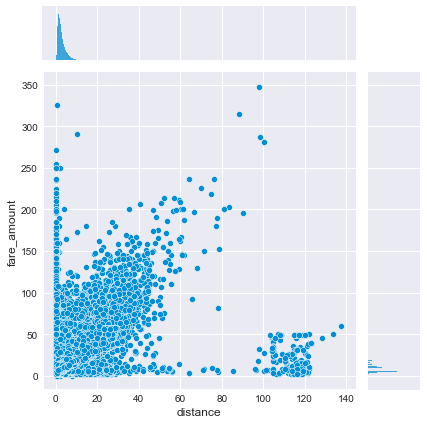

In [59]:
sns.jointplot(x='distance', y='fare_amount', data=train_dataset)

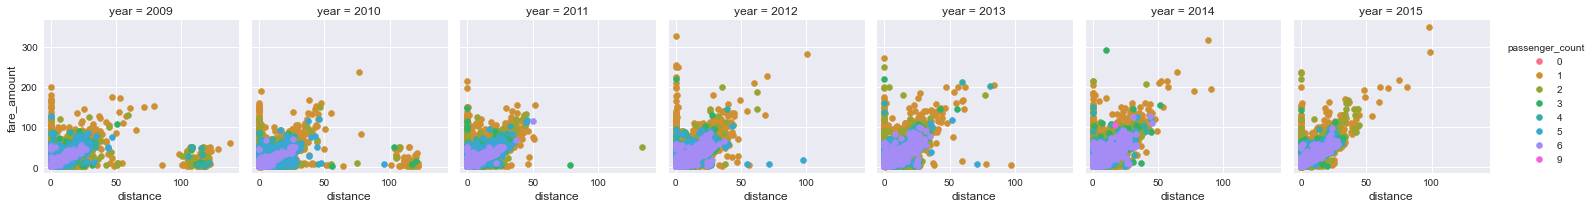

In [60]:
g = sns.FacetGrid(train_dataset, col="year", hue="passenger_count")
g.map(plt.scatter, "distance", "fare_amount")
g.add_legend()

In [61]:
train_dataset[(train_dataset.distance>90) & (train_dataset.fare_amount<70)]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,day_of_week,distance
1684,2.500000,2009-05-02 19:01:01+00:00,-73.137390,41.366138,-73.996513,40.745319,2,19,2,5,2009,5,117.856644
3075,6.900000,2009-01-06 10:53:36+00:00,-73.137390,41.366138,-73.974602,40.751312,1,10,6,1,2009,1,115.495064
4487,4.900000,2009-08-26 07:43:16+00:00,-73.137390,41.366138,-73.957687,40.765644,1,7,26,8,2009,2,113.035820
5663,49.150002,2009-02-25 07:05:05+00:00,-73.137390,41.366138,-74.000938,40.731724,1,7,25,2,2009,2,119.144707
7401,4.500000,2009-07-16 09:41:26+00:00,-73.900574,40.764046,-73.137390,41.366138,1,9,16,7,2009,3,108.087029
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945268,30.670000,2009-11-30 06:58:33+00:00,-73.137390,41.366138,-73.982132,40.748924,1,6,30,11,2009,0,116.327293
1949414,5.700000,2010-05-04 09:43:19+00:00,-73.137390,41.366138,-73.966904,40.766396,1,9,4,5,2010,1,113.815704
1954562,21.299999,2010-06-19 15:57:36+00:00,-73.137390,41.366138,-73.962921,40.809269,1,15,19,6,2010,5,110.722160
1975510,2.500000,2009-05-05 23:28:42+00:00,-73.980354,40.746719,-73.137390,41.366138,1,23,5,5,2009,1,116.312805


<AxesSubplot:xlabel='day_of_week', ylabel='count'>

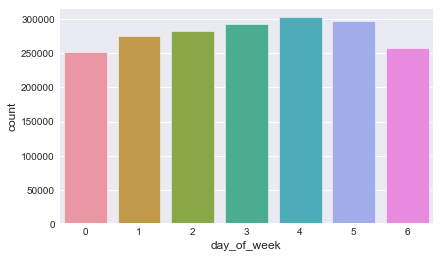

In [62]:
sns.countplot(x='day_of_week', data=train_dataset)

<AxesSubplot:xlabel='month', ylabel='day_of_week'>

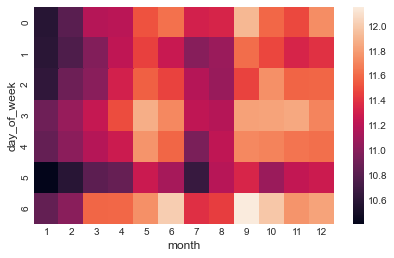

In [64]:
tc = train_dataset.pivot_table(index='day_of_week', columns='month', values='fare_amount')
sns.heatmap(data = tc)

In [65]:
train_dataset['fare_amount'].skew()

3.579451

C:\Users\98001\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

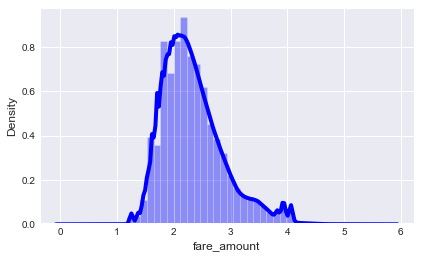

In [66]:
train_dataset['fare_amount'] = np.log1p(train_dataset['fare_amount'])
sns.distplot(train_dataset['fare_amount'], color='blue')

## Model performance

In [ ]:
selected_predictors = [
    'pickup_longitude', 
    'pickup_latitude', 
    'dropoff_longitude', 
    'dropoff_latitude',
    'pickup_jfk_distance',
    'dropof_jfk_distance',
    'pickup_ewr_distance',
    'dropof_ewr_distance',
    'pickup_lga_distance',
    'dropof_lga_distance',
    'hour',
    'month',
    'year',
    'distance'
]

X = train_dataset.loc[:, selected_predictors].values
y = train_dataset.iloc[:, 0].values
X_test_dataset = test_dataset.loc[:, selected_predictors].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/20)

### Random Forest

In [78]:
rand_forest_regressor = RandomForestRegressor()
rand_forest_regressor.fit(X_train, y_train)

y_rand_forest_predict = rand_forest_regressor.predict(X_test)
random_forest_model_error = sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_rand_forest_predict)))
print(f' Random Forest Mean Squared Error - {random_forest_model_error}')

 Random Forest Mean Squared Error - 3.74672354647878


### XGBoost

In [84]:
XGB_model = XGBRegressor(learning_rate=0.3, max_depth=6, n_estimators=500)
XGB_model.fit(X_train, y_train)
y_XGB_predict = XGB_model.predict(X_test)

XGB_model_error = sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_XGB_predict)))

print(f'XGBoost Mean Squared Error - {XGB_model_error}')

XGBoost Mean Squared Error - 3.7125776340574763


### LightGBM

In [86]:
lgb_model = lgb.LGBMRegressor(objective='regression',num_leaves=35, n_estimators=300)

lgb_model.fit(X_train, y_train)
y_LGB_predict = lgb_model.predict(X_test)

LGB_model_error = sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_LGB_predict)))

print(f'LGBM Mean Squared Error - {LGB_model_error}')

LGBM Mean Squared Error - 3.774030639044386


### Final model - stacked ensemble XGBoost and LightGBM

In [87]:
ensembled_prediction = (0.5*np.expm1(y_XGB_predict))+(0.5*np.expm1(y_LGB_predict))
ensembled_prediction_error = sqrt(mean_squared_error(np.expm1(y_test), ensembled_prediction))

print(f'Ensembled Mean Squared Error - {ensembled_prediction_error}')

Ensembled Mean Squared Error - 3.667128615645135


In [88]:
y_XGB_predict = np.expm1(XGB_model.predict(X_test_dataset))

# submitting our predictions
submission = pd.read_csv('sample_submission.csv')
submission['fare_amount'] = y_XGB_predict
submission.to_csv('xgb_submission.csv', index=False)
submission.head(10)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.529562
1,2015-01-27 13:08:24.0000003,11.000352
2,2011-10-08 11:53:44.0000002,4.738966
3,2012-12-01 21:12:12.0000002,8.468833
4,2012-12-01 21:12:12.0000003,15.776497
5,2012-12-01 21:12:12.0000005,8.878024
6,2011-10-06 12:10:20.0000001,4.965949
7,2011-10-06 12:10:20.0000003,49.332458
8,2011-10-06 12:10:20.0000002,10.626863
9,2014-02-18 15:22:20.0000002,6.580334


In [89]:
y_LGB_predict = np.expm1(lgb_model.predict(X_test_dataset))

# submitting our predictions
submission = pd.read_csv('sample_submission.csv')
submission['fare_amount'] = y_LGB_predict
submission.to_csv('lgbm_submission.csv', index=False)
submission.head(10)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.345402
1,2015-01-27 13:08:24.0000003,10.548257
2,2011-10-08 11:53:44.0000002,4.462809
3,2012-12-01 21:12:12.0000002,8.302775
4,2012-12-01 21:12:12.0000003,15.628836
5,2012-12-01 21:12:12.0000005,9.250434
6,2011-10-06 12:10:20.0000001,5.162352
7,2011-10-06 12:10:20.0000003,50.276849
8,2011-10-06 12:10:20.0000002,11.045936
9,2014-02-18 15:22:20.0000002,6.841322


In [90]:
ensembled_prediction = (0.5*y_XGB_predict)+(0.5*y_LGB_predict)
submission.to_csv('ensembled_submission.csv', index=False)
submission.head(10)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.345402
1,2015-01-27 13:08:24.0000003,10.548257
2,2011-10-08 11:53:44.0000002,4.462809
3,2012-12-01 21:12:12.0000002,8.302775
4,2012-12-01 21:12:12.0000003,15.628836
5,2012-12-01 21:12:12.0000005,9.250434
6,2011-10-06 12:10:20.0000001,5.162352
7,2011-10-06 12:10:20.0000003,50.276849
8,2011-10-06 12:10:20.0000002,11.045936
9,2014-02-18 15:22:20.0000002,6.841322
